In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   
import gdown

## Loading and cleaning

In [62]:
# # Loading data from GDrive.
# 
# # Data with BDL merged,
# file_id = "1SYvX9OHdWpuDWgYSWIfnZHJy2DL0p5lN"
# url = f"https://drive.google.com/uc?id={file_id}"
# file_extension = "downloaded_file.csv"
# gdown.download(url, file_extension, quiet=False)
# df = pd.read_csv(file_extension, sep=",")

In [63]:
# temp
df = pd.read_csv('merged_bdl.csv')

In [64]:
# Dropping data from 2017: too few records.
df = df[df['year'] > 2017]

# Dropping advertised_institution (too many nulls).
df.drop(['advertised_institution'], axis=1, inplace=True)

In [65]:
# Changing commas to dots in decimals.
df.loc['unemployment', :] = df['unemployment'].str.replace(",", ".", regex=False).astype(float)

In [66]:
# Changing "," to "." in numerical variables.
comma_cols_to_replace = {
    'mediana_wieku': 'bdl_age_median',
    'wydatki_powiat': 'bdl_district_expenses',
    'wynagrodzenia': 'bdl_average_salary'
}

# Replace commas with dots and convert to float.
for old_col, new_col in comma_cols_to_replace.items():
    try:
        df[new_col] = df[old_col].str.replace(',', '.', regex=False).astype(float)
    except AttributeError:
        df[new_col] = df[old_col]
        continue

df.drop(columns=comma_cols_to_replace.keys(), inplace=True)

In [67]:
# Other columns to rename.
col_names_to_replace = {
    'cena_mieszkan': 'bdl_avg_house_pricing',
    'saldo_migracji': 'bdl_migration_coefficient',
    'wsp_feminizacji': 'bdl_feminization_coefficient'
}

for old_col, new_col in col_names_to_replace.items():
    df[new_col] = df[old_col].astype(float)
    df.drop([old_col], axis=1, inplace=True)

In [68]:
df['work_time_over_1'] = (df['work_time'] > 1).astype(int)
df['full_time_job'] = (df['work_time'] == 1).astype(int)
df['work_time_below_1'] = (df['work_time'] < 1).astype(int)
df.drop(['work_time'], axis=1, inplace=True)

In [69]:
df = df[df['ad_views'].notnull()]

In [70]:
# We're not interested in these variables:
# - women_percentage, bdl_feminization_coefficient: low variability
# - bdl_district_expenses: too many nulls
# - applicants: that's what we're measuring, so adding that variable wouldn't make sense
df.drop(['women_percentage', 'bdl_feminization_coefficient', 'applicants', 'bdl_district_expenses'], axis=1, inplace=True)

## Imputation

In [71]:
# Imputing values for salary_for_position, since this variable has relatively low variance and is potentially of greater importance.
# However, imputing at institution-level won't solve the problem completely,
# since for some institutions, years or districts there was no data about salary at all.
# What is more, there was no salary data for średni szczebel zarządzania position category in the original data.
# Fortunately, that information was available here:
# https://dane.gov.pl/pl/dataset/1579/resource/56259,przecietne-wynagrodzenie-cakowite-wedug-grup-stanowisk-2023-r/table?page=1&per_page=20&q=&sort=
# For this reason, 6 imputations are needed (the sequence matters).

df_for_imputation_institution_level = df[df['salary_for_position'].notnull()]
df_for_imputation_district_level = df[df['salary_for_position'].notnull()]
df_for_imputation_voivodeship_level = df[df['salary_for_position'].notnull()]
df_for_imputation_year_level = df[df['salary_for_position'].notnull()]
df_for_imputation_category_level = df[df['salary_for_position'].notnull()]

df_for_imputation_institution_level = (
    df_for_imputation_institution_level
    .groupby(['district', 'voivodeship', 'institution', 'year', 'position_category'])['salary_for_position']
    .median()
    .reset_index()
    .rename(columns={'salary_for_position': 'median_institution'})
)

df_for_imputation_district_level = (
    df_for_imputation_district_level
    .groupby(['district', 'voivodeship', 'year', 'position_category'])['salary_for_position']
    .median()
    .reset_index()
    .rename(columns={'salary_for_position': 'median_district'})
)

df_for_imputation_voivodeship_level = (
    df_for_imputation_voivodeship_level
    .groupby(['voivodeship', 'year', 'position_category'])['salary_for_position']
    .median()
    .reset_index()
    .rename(columns={'salary_for_position': 'median_voivodeship'})
)

df_for_imputation_year_level = (
    df_for_imputation_year_level
    .groupby(['year', 'position_category'])['salary_for_position']
    .median()
    .reset_index()
    .rename(columns={'salary_for_position': 'median_year'})
)

df_for_imputation_category_level = (
    df_for_imputation_category_level
    .groupby(['position_category'])['salary_for_position']
    .median()
    .reset_index()
    .rename(columns={'salary_for_position': 'median_category'})
)


df = df.merge(df_for_imputation_institution_level, on=['district', 'voivodeship', 'institution', 'year', 'position_category'], how='left')
df = df.merge(df_for_imputation_district_level, on=['district', 'voivodeship', 'year', 'position_category'], how='left')
df = df.merge(df_for_imputation_voivodeship_level, on=['voivodeship', 'year', 'position_category'], how='left')
df = df.merge(df_for_imputation_year_level, on=['year', 'position_category'], how='left')
df = df.merge(df_for_imputation_category_level, on=['position_category'], how='left')

df['salary_for_position'] = df['salary_for_position'].fillna(df['median_institution'])
df['salary_for_position'] = df['salary_for_position'].fillna(df['median_district'])
df['salary_for_position'] = df['salary_for_position'].fillna(df['median_voivodeship'])
df['salary_for_position'] = df['salary_for_position'].fillna(df['median_year'])
df['salary_for_position'] = df['salary_for_position'].fillna(df['median_category'])

df = df.drop(columns=['median_institution', 'median_category', 'median_district', 'median_voivodeship', 'median_year'], axis=1)

# Assigning mean salaries for sredni szczebel zarzadzania manually (from the mentioned link):
mean_sredni_szczebel_2023 = 13160
mean_sredni_szczebel_2022 = 11322
mean_sredni_szczebel_2021 = 10579
mean_sredni_szczebel_2020 = 12633
mean_sredni_szczebel_2019 = 11693
mean_sredni_szczebel_2018 = 11088

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2023),
    'salary_for_position'
] = mean_sredni_szczebel_2023

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2022),
    'salary_for_position'
] = mean_sredni_szczebel_2022

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2021),
    'salary_for_position'
] = mean_sredni_szczebel_2021

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2020),
    'salary_for_position'
] = mean_sredni_szczebel_2020

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2019),
    'salary_for_position'
] = mean_sredni_szczebel_2019

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2018),
    'salary_for_position'
] = mean_sredni_szczebel_2018

In [72]:
# Fluctuation

df_for_imputation_institution_level = df[df['fluctuation'].notnull()]
df_for_imputation_district_level = df[df['fluctuation'].notnull()]
df_for_imputation_voivodeship_level = df[df['fluctuation'].notnull()]
df_for_imputation_year_level = df[df['fluctuation'].notnull()]

df_for_imputation_institution_level = (
    df_for_imputation_institution_level
    .groupby(['district', 'voivodeship', 'institution', 'year'])['fluctuation']
    .median()
    .reset_index()
    .rename(columns={'fluctuation': 'median_institution'})
)

df_for_imputation_district_level = (
    df_for_imputation_district_level
    .groupby(['district', 'voivodeship', 'year'])['fluctuation']
    .median()
    .reset_index()
    .rename(columns={'fluctuation': 'median_district'})
)

df_for_imputation_voivodeship_level = (
    df_for_imputation_voivodeship_level
    .groupby(['voivodeship', 'year'])['fluctuation']
    .median()
    .reset_index()
    .rename(columns={'fluctuation': 'median_voivodeship'})
)

df_for_imputation_year_level = (
    df_for_imputation_year_level
    .groupby(['year'])['fluctuation']
    .median()
    .reset_index()
    .rename(columns={'fluctuation': 'median_year'})
)


df = df.merge(df_for_imputation_institution_level, on=['district', 'voivodeship', 'institution', 'year'], how='left')
df = df.merge(df_for_imputation_district_level, on=['district', 'voivodeship', 'year'], how='left')
df = df.merge(df_for_imputation_voivodeship_level, on=['voivodeship', 'year'], how='left')
df = df.merge(df_for_imputation_year_level, on=['year'], how='left')

df['fluctuation'] = df['salary_for_position'].fillna(df['median_institution'])
df['fluctuation'] = df['salary_for_position'].fillna(df['median_district'])
df['fluctuation'] = df['salary_for_position'].fillna(df['median_voivodeship'])
df['fluctuation'] = df['salary_for_position'].fillna(df['median_year'])

df = df.drop(columns=['median_institution', 'median_district', 'median_voivodeship', 'median_year'], axis=1)

In [73]:
# Employment contract

df_for_imputation_institution_level = df[df['employment_contract'].notnull()]
df_for_imputation_district_level = df[df['employment_contract'].notnull()]
df_for_imputation_voivodeship_level = df[df['employment_contract'].notnull()]
df_for_imputation_year_level = df[df['employment_contract'].notnull()]

df_for_imputation_institution_level = (
    df_for_imputation_institution_level
    .groupby(['district', 'voivodeship', 'institution', 'year'])['employment_contract']
    .median()
    .reset_index()
    .rename(columns={'employment_contract': 'median_institution'})
)

df_for_imputation_district_level = (
    df_for_imputation_district_level
    .groupby(['district', 'voivodeship', 'year'])['employment_contract']
    .median()
    .reset_index()
    .rename(columns={'employment_contract': 'median_district'})
)

df_for_imputation_voivodeship_level = (
    df_for_imputation_voivodeship_level
    .groupby(['voivodeship', 'year'])['employment_contract']
    .median()
    .reset_index()
    .rename(columns={'employment_contract': 'median_voivodeship'})
)

df_for_imputation_year_level = (
    df_for_imputation_year_level
    .groupby(['year'])['employment_contract']
    .median()
    .reset_index()
    .rename(columns={'employment_contract': 'median_year'})
)


df = df.merge(df_for_imputation_institution_level, on=['district', 'voivodeship', 'institution', 'year'], how='left')
df = df.merge(df_for_imputation_district_level, on=['district', 'voivodeship', 'year'], how='left')
df = df.merge(df_for_imputation_voivodeship_level, on=['voivodeship', 'year'], how='left')
df = df.merge(df_for_imputation_year_level, on=['year'], how='left')

df['employment_contract'] = df['employment_contract'].fillna(df['median_institution'])
df['employment_contract'] = df['employment_contract'].fillna(df['median_district'])
df['employment_contract'] = df['employment_contract'].fillna(df['median_voivodeship'])
df['employment_contract'] = df['employment_contract'].fillna(df['median_year'])

df = df.drop(columns=['median_institution', 'median_district', 'median_voivodeship', 'median_year'], axis=1)

## Feature engineering

In [74]:
df['offer_salary'].replace("nie podano wynagrodzenia", np.nan, inplace=True)
df['offer_salary_mentioned'] = df['offer_salary'].notna().astype(int)
df.drop(['offer_salary'], axis=1, inplace=True)

C:\Users\KW\AppData\Local\Temp\ipykernel_5912\1148810047.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['offer_salary'].replace("nie podano wynagrodzenia", np.nan, inplace=True)


In [75]:
df['len_requirements'] = df['requirements'].str.count("|-|") + 1
df['len_nice_to_have'] = df['nice_to_have'].str.count("|-|") + 1
df['len_responsibilities'] = df['responsibilities'].str.count("|-|") + 1

# null for nice-to-have means no nice-to-have.
df.loc[df['nice_to_have'].isnull(), 'nice_to_have'] = 0

df.drop(['requirements', 'nice_to_have', 'responsibilities'], axis=1, inplace=True)

## Analyses

##### Correlation

In [76]:
from scipy import stats
# Variable correlation.

# From scipy documentation:
# "Calculates a point biserial correlation coefficient and the associated p-value.
# The point biserial correlation is used to measure the relationship between a binary variable, x, and a continuous variable, y. Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply a determinative relationship".

numerical_columns = [
    'ad_views',
    'offer_salary_mentioned',
    'salary_for_position',
    'fluctuation',
    'employment_contract',
    'bdl_avg_house_pricing',
    'bdl_age_median',
    'bdl_migration_coefficient',
    'bdl_average_salary',
    'vacancies',
    'len_requirements',
    'len_nice_to_have',
    'len_responsibilities'
]

correlation_results = {}
for col in numerical_columns:
    x = df['result']
    y = df[col]
    valid = x.notna() & y.notna()
    r, p = stats.pointbiserialr(x[valid], y[valid])
    correlation_results[col] = {
        'correlation': r,
        'is_statistically_significant': int(p <= 0.05)
    }

correlation_df = pd.DataFrame.from_dict(correlation_results, orient='index')
correlation_df = correlation_df.sort_values(by='is_statistically_significant', ascending=False)

print(correlation_df)

                           correlation  is_statistically_significant
ad_views                      0.228419                             1
offer_salary_mentioned        0.061931                             1
salary_for_position          -0.106261                             1
fluctuation                  -0.106261                             1
employment_contract           0.016250                             1
bdl_avg_house_pricing        -0.079839                             1
bdl_age_median                0.014042                             1
bdl_migration_coefficient    -0.050311                             1
bdl_average_salary           -0.086909                             1
vacancies                     0.066639                             1
len_requirements             -0.066969                             1
len_responsibilities         -0.103283                             1
len_nice_to_have              0.001840                             0


In [77]:
# excluding len_nice_to_have since it's statistically insignificant
df.drop(['len_nice_to_have'], axis=1, inplace=True)
numerical_columns.remove('len_nice_to_have')

In [78]:
df[numerical_columns].describe()

,ad_views,offer_salary_mentioned,salary_for_position,fluctuation,employment_contract,bdl_avg_house_pricing,bdl_age_median,bdl_migration_coefficient,bdl_average_salary,vacancies,len_requirements,len_responsibilities
count,99330.000000,99330.000000,99330.000000,99330.000000,99330.000000,99330.000000,99330.000000,99330.000000,99330.000000,99330.000000,99330.000000,99330.000000
mean,2065.149864,0.268902,6053.696420,6053.696420,566.918181,7085.248243,41.957533,2768.213198,6394.208979,1.115836,662.222863,1052.177811
std,844.083530,0.443391,1676.759860,1676.759860,656.274593,2937.806550,1.785236,3996.190526,1508.119031,0.453799,327.609146,590.846405
min,124.000000,0.000000,990.833333,990.833333,0.010000,0.000000,34.600000,-1065.000000,3183.340000,1.000000,132.000000,19.000000
25%,1335.000000,0.000000,4833.879387,4833.879387,16.000000,4720.000000,40.700000,-173.000000,5238.030000,1.000000,417.000000,625.000000
50%,2145.500000,0.000000,5833.339921,5833.339921,275.070000,6596.000000,41.500000,143.000000,6432.780000,1.000000,611.000000,937.000000
75%,2621.000000,1.000000,6831.692744,6831.692744,820.250000,8907.000000,43.300000,6224.000000,7391.950000,1.000000,829.000000,1373.000000
max,11911.000000,1.000000,22911.326995,22911.326995,3271.880000,15717.000000,48.900000,11727.000000,12804.030000,5.000000,4339.000000,8690.000000


##### Bar charts

In [79]:
def plot_ibcs_bar_chart(df: pd.DataFrame, group_col: str):

    group_means = df.groupby(group_col)['result'].mean().reset_index()
    group_means.sort_values(by='result', ascending=False, inplace=True)

    ibcs_palette = ['#000000', '#444444', '#777777', '#AAAAAA', '#DDDDDD']
    sns.set(style='whitegrid')
    
    plt.figure(figsize=(15, 7))
    ax = sns.barplot(
        x=group_col, 
        y='result', 
        data=group_means, 
        palette=ibcs_palette[:len(group_means)],
        edgecolor='black'
    )

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',
                    fontsize=13, fontweight='bold')

    ax.set_title(f"Mean result by {group_col}", fontsize=14, weight='bold')
    ax.set_ylabel("Mean result", fontsize=12)
    ax.set_xlabel(group_col, fontsize=12)
    ax.tick_params(axis='x', labelsize=12)
    sns.despine()
    
    plt.tight_layout()
    plt.show()

C:\Users\KW\AppData\Local\Temp\ipykernel_5912\1369376441.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


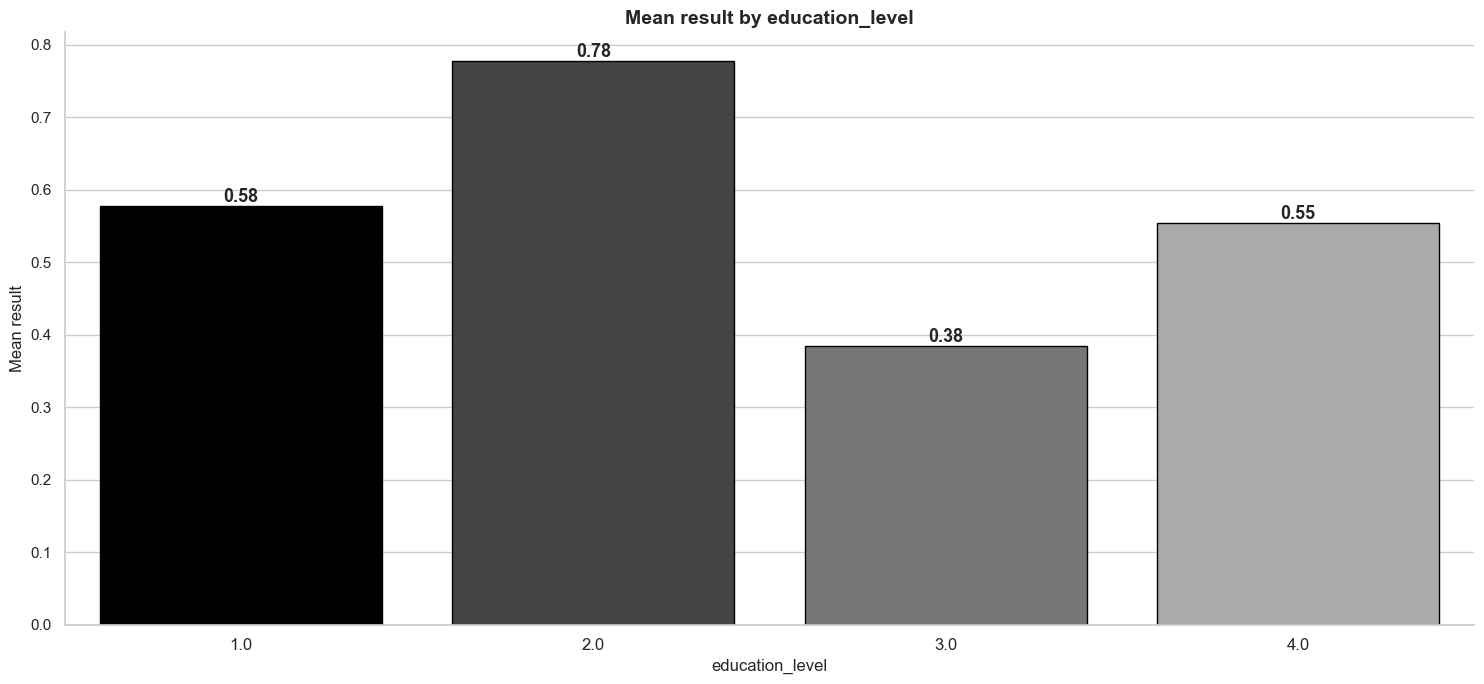

C:\Users\KW\AppData\Local\Temp\ipykernel_5912\1369376441.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
C:\Users\KW\AppData\Local\Temp\ipykernel_5912\1369376441.py:10: UserWarning: 
The palette list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(


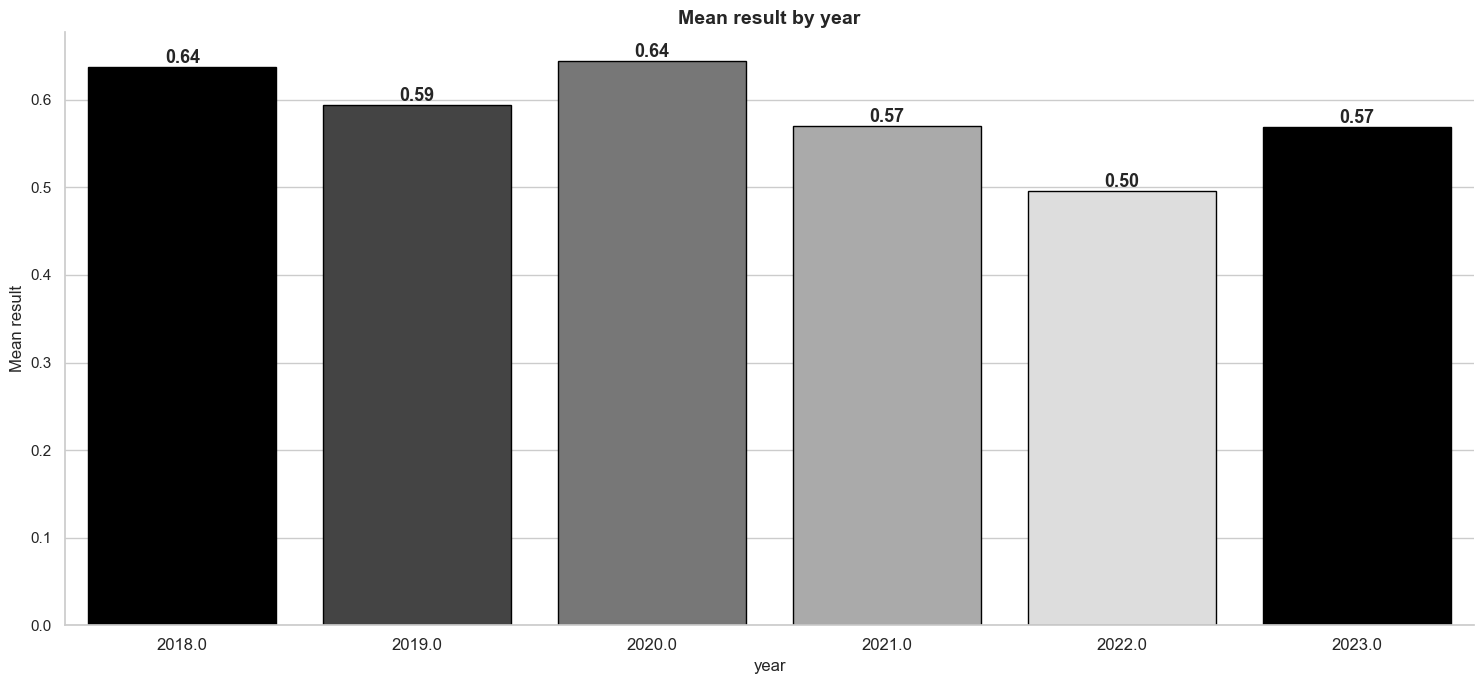

C:\Users\KW\AppData\Local\Temp\ipykernel_5912\1369376441.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
C:\Users\KW\AppData\Local\Temp\ipykernel_5912\1369376441.py:10: UserWarning: 
The palette list has fewer values (5) than needed (11) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(


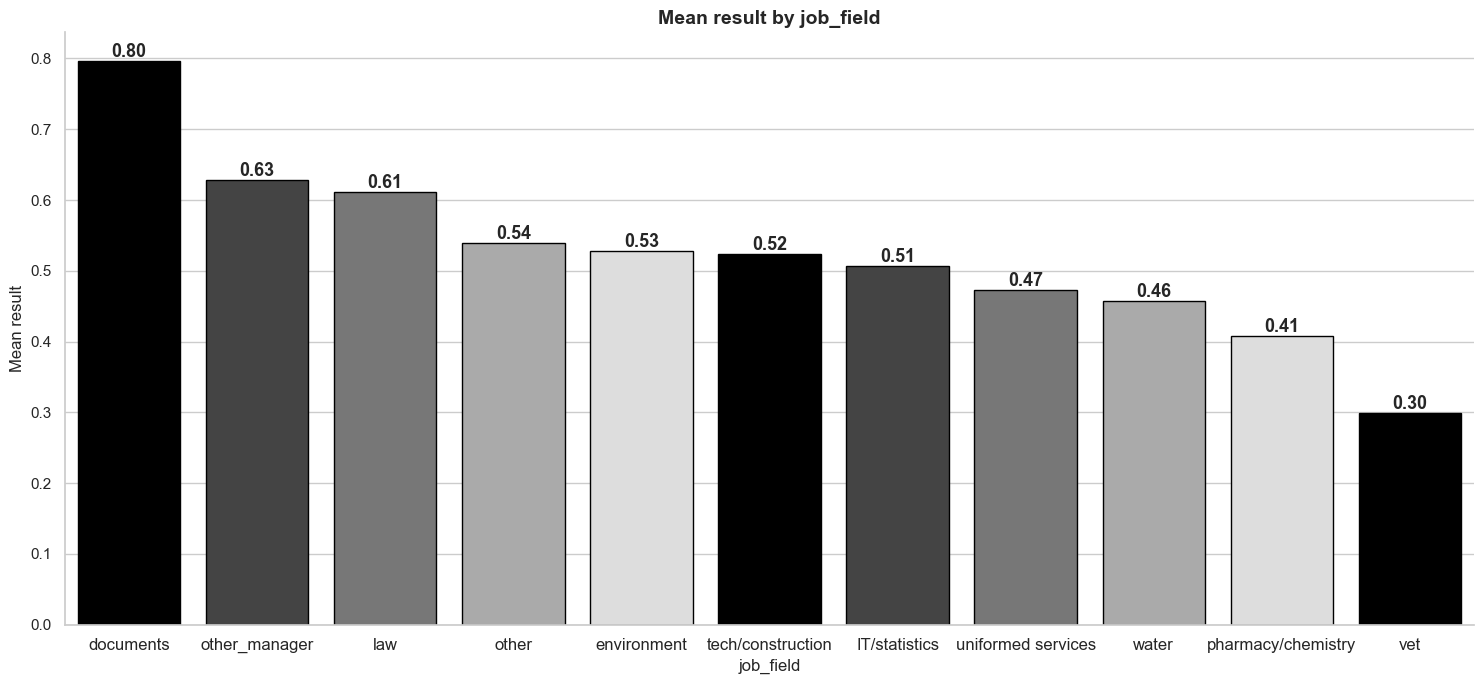

C:\Users\KW\AppData\Local\Temp\ipykernel_5912\1369376441.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
C:\Users\KW\AppData\Local\Temp\ipykernel_5912\1369376441.py:10: UserWarning: 
The palette list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(


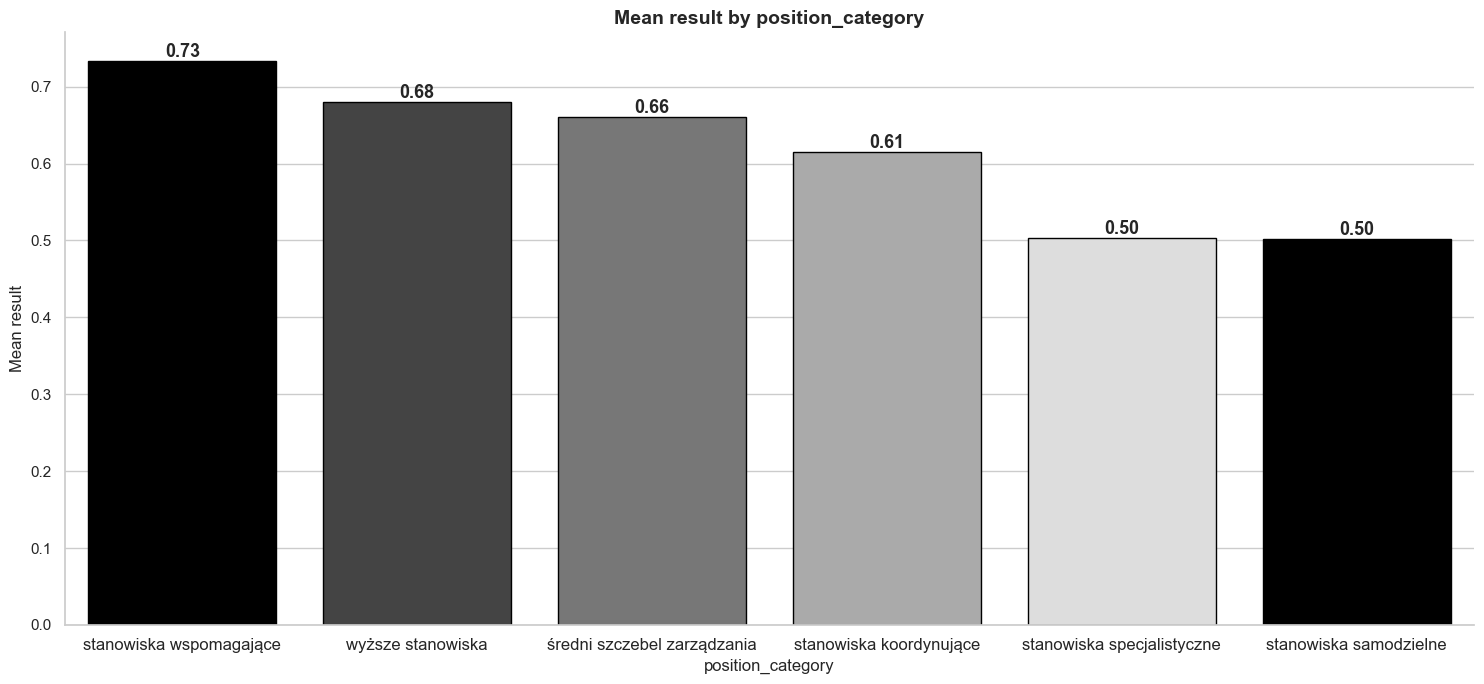

In [80]:
plot_bar_columns = [
    'education_level',
    'year',
    'job_field',
    'position_category'
]

for column in plot_bar_columns:
    plot_ibcs_bar_chart(df, column)

In [81]:
# Dealing with categorical columns.
df = pd.get_dummies(df, columns=['position_category', 'job_field'], drop_first=True, dtype=int)

##### Time series

In [95]:
# Dropping cols unnecessary for statistical analyses.
string_cols_for_temporary_dropping = [
    'ad_id',
    'institution_address',
    'workplace',
    'department',
    'date_announced',
    'institution_address',
    'workplace',
    'department',
    'city',
    'position'
]

df_for_charts = df.drop(string_cols_for_temporary_dropping, axis=1)
df_for_charts["voivodeship_district"] = df_for_charts['voivodeship'].astype(str) + df_for_charts['district'].astype(str)

In [96]:
# def plot_individual_time_series(dataframe):
#     exclude_columns = ['voivodeship', 'district', 'education_level', 'work_time', 'institution']
#     df_grouped = dataframe.groupby('year').mean(numeric_only=True)
#     columns_to_plot = [col for col in df_grouped.columns if col not in exclude_columns]
# 
#     sns.set(style="whitegrid", context="talk", palette="deep")
# 
#     for column in columns_to_plot:
#         plt.figure(figsize=(12, 6))
#         sns.lineplot(x=df_grouped.index, y=df_grouped[column], marker='o', linewidth=2.5)
#         plt.title(f"{column.replace('_', ' ').title()} Over Time", fontsize=16, weight='bold')
#         plt.xlabel("Year", fontsize=13)
#         plt.ylabel(column.replace('_', ' ').title(), fontsize=13)
#         plt.xticks(fontsize=11)
#         plt.yticks(fontsize=11)
#         plt.grid(visible=True, linestyle='--', alpha=0.7)
#         plt.tight_layout()
#         plt.show()
#         
# plot_individual_time_series(df_for_charts)

##### Variability charts

In [97]:
# def plot_variability(dataframe):
#     exclude_columns = ['work_time', 'year', 'district', 'voivodeship', 'institution']
#     df_grouped = dataframe.groupby('district').mean(numeric_only=True)
#     columns_to_plot = [col for col in df_grouped.columns if col not in exclude_columns]
# 
#     sns.set(style="whitegrid", context="talk", palette="deep")
# 
#     for column in columns_to_plot:
#         plt.figure(figsize=(12, 6))
#         sns.lineplot(x=df_grouped.index, y=df_grouped[column], marker='o', linewidth=2.5)
#         plt.title(f"{column.replace('_', ' ').title()} District Variability", fontsize=16, weight='bold')
#         plt.xlabel("District", fontsize=13)
#         plt.ylabel(column.replace('_', ' ').title(), fontsize=13)
#         plt.xticks(rotation=45, fontsize=11)
#         plt.yticks(fontsize=11)
#         plt.grid(visible=True, linestyle='--', alpha=0.7)
#         plt.tight_layout()
#         plt.show()
# 
# plot_variability(df_for_charts)

##### Spaghetti plots

In [98]:
df_for_charts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99330 entries, 0 to 99329
Data columns (total 39 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   result                                         99330 non-null  float64
 1   education_level                                99330 non-null  float64
 2   vacancies                                      99330 non-null  float64
 3   institution                                    99330 non-null  object 
 4   ad_views                                       99330 non-null  float64
 5   year                                           99330 non-null  float64
 6   salary_for_position                            99330 non-null  float64
 7   fluctuation                                    99330 non-null  float64
 8   employment_contract                            99330 non-null  float64
 9   voivodeship                                    993

In [99]:
df_for_charts_district_agg = df_for_charts.groupby(by=['voivodeship_district', 'year'])['result'].mean()
df_for_charts_institution_agg = df_for_charts.groupby(by=['institution', 'year'])['result'].mean()

In [102]:
def plot_spaghetti_chart(df_grouped, group_cols):
    df = df_grouped.reset_index()
    
    groups = df.groupby(group_cols)

    plt.figure(figsize=(10, 6))
    for group_vals, group_data in groups:
        label = '-'.join(map(str, group_vals)) if isinstance(group_vals, tuple) else str(group_vals)
        plt.plot(group_data['year'], group_data['result'], label=label)

    plt.xlabel('Year')
    plt.ylabel('Result')
    plt.title('Spaghetti Chart')
    plt.legend(title='Group', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

C:\Users\KW\AppData\Local\Temp\ipykernel_5912\3387404042.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


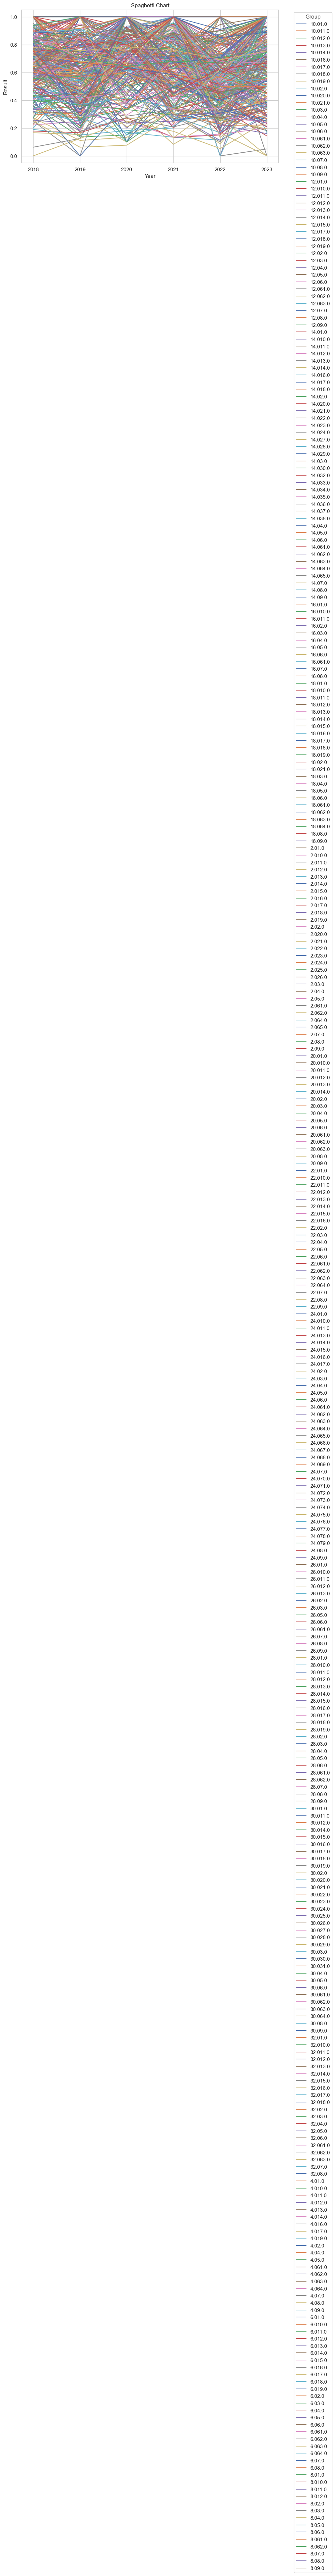

In [103]:
plot_spaghetti_chart(df_for_charts_district_agg, ['voivodeship_district'])

In [105]:
# plot_spaghetti_chart(df_for_charts_institution_agg, ['institution'])

## Feature importance

##### Generalized Linear Mixed Models

In [ ]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM



##### Conclusions

In [ ]:
# # As a result of the above analyses, I decided to exclude certain columns due to their low variability or low correlation.
# 
# cols_to_exclude = [
#     'women_percentage',
#     'bdl_feminization_coefficient',
#     'work_time',
#     'job_field_documents',
#     'job_field_environment',
#     'bdl_age_median',
#     'job_field_water',
#     'bdl_avg_house_pricing',
#     'vacancies',
#     'fluctuation',
#     'salary_for_position'
# ]
# 
# df_institution_level = df_institution_level.drop(columns=cols_to_exclude, axis=1)